In [2]:
import networkx as net 
import urllib



In [3]:
g = net.Graph()
g.add_edge('a','b')

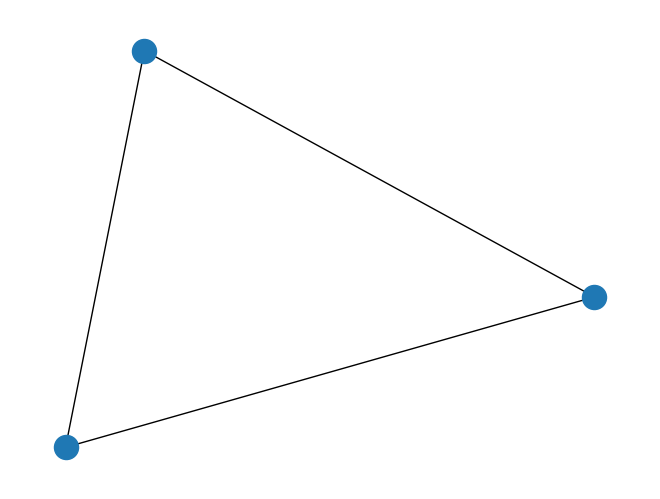

In [ ]:
g.add_edge('b','c')
g.add_edge('c','a')
net.draw(g)

In [5]:
g.nodes()

NodeView(('a', 'b', 'c'))

In [6]:
g.edges()

EdgeView([('a', 'b'), ('a', 'c'), ('b', 'c')])

In [8]:
g.nodes['a']

{}

In [9]:
g.nodes['a']['size'] = 1
g.nodes['a']

{'size': 1}

In [10]:
g['a']

AtlasView({'b': {}, 'c': {}})

In [17]:

!curl "http://www.livejournal.com/misc/fdata.bml?user=valerois"

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>301 Moved Permanently</title>
</head><body>
<h1>Moved Permanently</h1>
<p>The document has moved <a href="https://www.livejournal.com/misc/fdata.bml?user=valerois">here</a>.</p>
<p>Additionally, a 301 Moved Permanently
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100   391  100   391    0     0    142      0  0:00:02  0:00:02 --:--:--   142


In [18]:
import requests

url = "http://www.livejournal.com/misc/fdata.bml?user=valerois"
response = requests.get(url)

print(response.text[:500])  # print first 500 chars

# Note: Polite data miners cache on their end.  Impolite ones get banned.
> bagira
> angerona
> yankel
> yelya
> ponka
> marinka
> saper
> levinius
> monella
> irbisa
> innaplanetyanka
> hutshepsut
> skyg74
> samoleg
> actr
> gottfrid
> krimsky
> nelis
> ptfenix
> a_u
> e_f
> boctok
> karial
> wattson
> baryshnia
> ntl
> salamandrina_
> ant_fugue
> levik
> _milashka
> oonabond
> alinaf
> vollalol
> kitobow
> petitmari
> babushonok
> koniglio
> berryl
> sylphida
> graier
> drunk_cherry
> mamarach


In [29]:
import networkx as nx
import requests

def read_lj_friends(G: nx.DiGraph, user: str):
    """
    Populate G with edges from LiveJournal fdata for `user`.
    Lines start with:
      '<username'  -> user follows 'username'
      '>username'  -> 'username' follows user
    """
    url = f"https://www.livejournal.com/misc/fdata.bml?user={user}"
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    for line in r.text.splitlines():
        if not line or line.startswith("#"):
            continue
        tag = line[0]
        friend = line[1:].strip()
        if not friend:
            continue
        if tag == '<':          # user -> friend
            G.add_edge(user, friend)
        elif tag == '>':        # friend -> user
            G.add_edge(friend, user)

# usage
G = nx.DiGraph()
read_lj_friends(G, "valerois")
len(G), G.number_of_edges()


(296, 421)

In [28]:
g= net.Graph()
read_lj_friends(g,'valerois')
len(g), g.number_of_edges()

(296, 295)

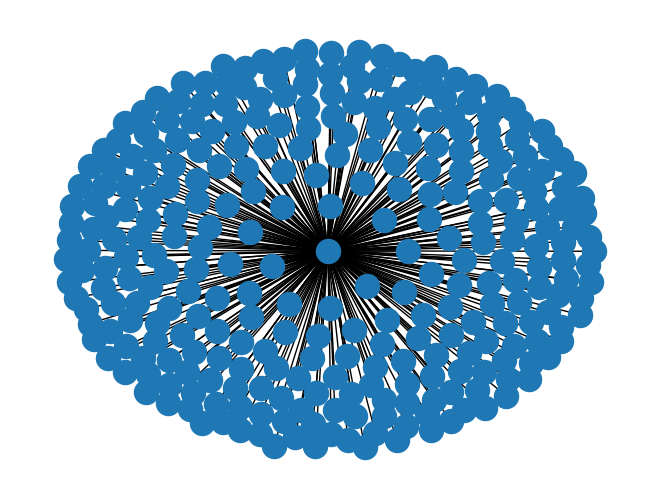

In [30]:
net.draw(g)

In [31]:
G = nx.DiGraph()
read_lj_friends(G, 'valerois')
ego = nx.ego_graph(G, "valerois")

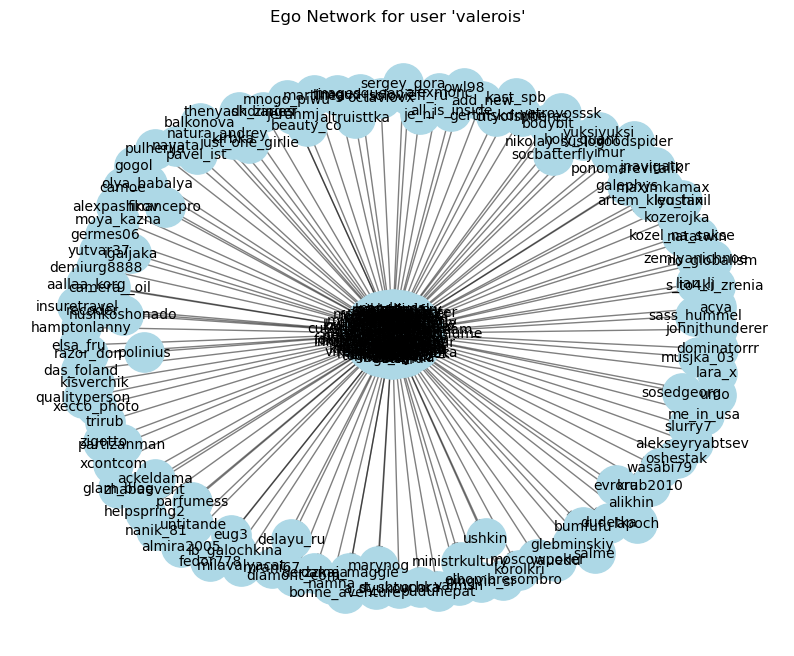

In [32]:
import matplotlib.pyplot as plt
# Draw with labels
plt.figure(figsize=(10,8))
pos = nx.spring_layout(ego, seed=42)   # force-directed layout
nx.draw_networkx_nodes(ego, pos, node_size=800, node_color="lightblue")
nx.draw_networkx_edges(ego, pos, arrows=True, alpha=0.5)
nx.draw_networkx_labels(ego, pos, font_size=10, font_color="black")

plt.title("Ego Network for user 'valerois'")
plt.axis("off")
plt.show()

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_clean(G, center, max_nodes=250, label_top=20):
    # take ego net and cap size for readability
    H = nx.ego_graph(G, center, radius=1)
    if H.number_of_nodes() > max_nodes:
        keep = {center} | set(sorted(H.degree, key=lambda x: x[1], reverse=True)[:max_nodes-1])
        H = H.subgraph([n for n,_ in keep]).copy()

    # node sizes by degree (scaled)
    deg = dict(H.degree())
    sizes = [80 + 15*deg[n] for n in H.nodes()]
    
    # color by direction relative to center (in/out/both)
    colors = []
    for n in H.nodes():
        if n == center: 
            colors.append("#3b82f6")       # blue center
            continue
        out_edge = G.has_edge(center, n)
        in_edge  = G.has_edge(n, center)
        if out_edge and in_edge: colors.append("#10b981")   # green = mutual
        elif out_edge:           colors.append("#f59e0b")   # orange = center -> n
        else:                    colors.append("#ef4444")   # red = n -> center

    pos = nx.spring_layout(H, k=0.35, seed=42)
    plt.figure(figsize=(11,9))
    nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=colors, alpha=0.9, linewidths=0.5, edgecolors="#333")
    nx.draw_networkx_edges(H, pos, arrows=True, alpha=0.35, width=0.6, arrowsize=8)
    
    # label only top-degree nodes (plus center)
    top = [n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:label_top]]
    label_nodes = set(top) | {center}
    nx.draw_networkx_labels(H, pos, labels={n:n for n in label_nodes}, font_size=8)
    
    plt.title(f"Ego Network for '{center}' — colors: mutual=green, out=orange, in=red")
    plt.axis("off"); plt.tight_layout(); plt.show()

# usage:
# plot_clean(G, "valerois")


In [34]:
def expand_depth2(G, center, per_neighbor=8):
    # take a handful of friends-of-friends to avoid explosion
    depth1 = list(G.successors(center)) + list(G.predecessors(center))
    depth1 = list(dict.fromkeys(depth1))  # unique, keep order
    keep = {center}
    for u in depth1:
        keep.add(u)
        nbrs = list(G.successors(u)) + list(G.predecessors(u))
        for v in nbrs[:per_neighbor]:
            keep.add(v)
    H = G.subgraph(keep).copy()
    return H

def plot_depth2(G, center):
    H = expand_depth2(G, center, per_neighbor=6)
    pos = nx.spring_layout(H, k=0.45, seed=7)
    plt.figure(figsize=(12,10))
    nx.draw_networkx_nodes(H, pos, node_size=40, node_color="#93c5fd", alpha=0.9)
    nx.draw_networkx_edges(H, pos, alpha=0.25, arrows=False, width=0.5)
    # label a few hubs only
    hubs = sorted(H.degree, key=lambda x:x[1], reverse=True)[:25]
    nx.draw_networkx_labels(H, pos, labels={n:n for n,_ in hubs}, font_size=7)
    nx.draw_networkx_labels(H, pos, labels={center:center}, font_size=9, font_color="black")
    plt.title(f"'{center}' — depth-2 sample (labels=hubs)"); plt.axis("off"); plt.tight_layout(); plt.show()

# usage:
# plot_depth2(G, "valerois")


In [38]:
from pyvis.network import Network

def interactive_vis(G, center, radius=1, notebook=False):
    H = nx.ego_graph(G, center, radius=radius)
    net = Network(height="700px", width="100%", directed=G.is_directed(), notebook=notebook)
    net.barnes_hut()
    for n in H.nodes():
        deg = H.degree(n)
        title = f"{n}<br>degree: {deg}"
        size = 10 + 2*deg
        net.add_node(n, label=n, title=title, size=size, color="#60a5fa" if n!=center else "#3b82f6")
    for u,v in H.edges():
        net.add_edge(u, v, opacity=0.4)
    net.show("ego_interactive.html")

# usage:
# interactive_vis(G, "valerois", radius=1, notebook=True)
# then open ego_interactive.html


In [41]:
from IPython.display import display, HTML

def interactive_vis(G, center, radius=1):
    H = nx.ego_graph(G, center, radius=radius)
    net = Network(height="700px", width="100%", directed=G.is_directed(), notebook=True)
    net.barnes_hut()
    for n in H.nodes():
        deg = H.degree(n)
        net.add_node(n, label=n, size=10+2*deg,
                     color="#60a5fa" if n != center else "#3b82f6")
    for u,v in H.edges():
        net.add_edge(u, v, opacity=0.4)
    
    return net.show("ego_interactive.html")

# usage
interactive_vis(G, "valerois", radius=1)
display(HTML("ego_interactive.html"))


ego_interactive.html


In [42]:
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame, display
import tempfile, os, webbrowser

def show_pyvis(G, center, radius=1, inline=True, open_browser=True):
    # small, readable subgraph
    H = nx.ego_graph(G, center, radius=radius)

    # KEY FIX: inline JS/CSS so it renders in VS Code/Jupyter without CDN
    net = Network(height="750px", width="100%", directed=G.is_directed(),
                  notebook=inline, cdn_resources="in_line")
    net.barnes_hut()

    # nodes/edges
    for n in H.nodes():
        deg = H.degree(n)
        net.add_node(n, label=n, size=10 + 2*deg,
                     color="#60a5fa" if n != center else "#3b82f6")
    for u, v in H.edges():
        net.add_edge(u, v, opacity=0.4)

    # write to a temp file
    html_path = os.path.join(tempfile.gettempdir(), "ego_interactive.html")
    net.show(html_path)

    # open in your default browser
    if open_browser:
        webbrowser.open("file://" + html_path)

    # also render inline (works in VS Code/Jupyter)
    if inline:
        return IFrame(src=html_path, width="100%", height=750)

# Example:
# show_pyvis(G, "valerois", radius=1)
